# Import package

In [1]:
from __future__ import division
from IPython.display import Audio,display
from collections import defaultdict
from PIL import Image

import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
import pylab
import librosa, librosa.display
import itertools
import os
import glob
import re
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (18,8)

# Load & Check mid file

In [2]:
# set directory
local_file_path = '../data/piano songs/*.mid'
# set image size
size = (224, 224)
# set sampling rate
sr = 22050 

In [3]:
# Check file list in folder
for file in glob.glob(local_file_path) :
    midi_fn = file
    pm = pretty_midi.PrettyMIDI(midi_fn)
    tmp_split = file.split('/')
    file_name = tmp_split[len(tmp_split)-1]
    file_name = file_name.split(".")[0]
    print(" ")
    print(file_name)
    print(" ")
    print(file_name,'\n',pm.instruments)

 
RiverFlowsInYou
 
RiverFlowsInYou 
 [Instrument(program=0, is_drum=False, name="Piano"), Instrument(program=0, is_drum=False, name="Track 2")]


/home/ubunt/anaconda3/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


# Extract spectrogram from mid

1 RiverFlowsInYou


/home/ubunt/anaconda3/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)
/home/ubunt/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '
/home/ubunt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes i

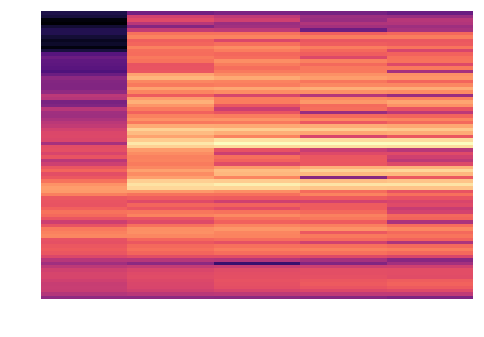

In [4]:
# files count
count=0
for j, file in enumerate(glob.glob(local_file_path)) :
    count += 1
    
    # save file name
    tmp_split = file.split('/')
    file_name = tmp_split[len(tmp_split)-1]
    file_name = file_name.split(".")[0]
    print(count, file_name)

    # Get the acoustic information from midi file
    midi_fn = file
    pm = pretty_midi.PrettyMIDI(midi_fn)
    
    # 미디파일 재생
    x = pm.fluidsynth(fs=sr)
    # cqt 변환
    D = librosa.cqt(x)
    
    # 눌린 시간 및 피치 탐색
    noteons = []
    pitchs = []
    onset_groups = defaultdict(set)
    pitch_groups = defaultdict(list)
    
    for instrument in pm.instruments: # 악기별로
        for note in instrument.notes: # 눌린 음, 시간 저장
            if note.start >= 0 and note.start <= (len(x)/sr): # 초단위
                noteons.append(note.start) # 시간
                onset_groups[note.start].add(note.pitch) # 음
    
    # 중복제거 및 시간 순 정렬
    noteons = list(set(noteons)) 
    noteons.sort()
    
    # 시간을 frame단위로 변환
    noteons_frame=librosa.time_to_frames(noteons)

    inputs = []
    
    # 눌린 음 기준 좌우 5frame으로 crop
    for o in noteons_frame:
        inputs.append(D[:,o:(o+5)])
    
    # array 변환 및 input 조정
    inputs = np.array(inputs)
    inputs = np.swapaxes(inputs,1,2)
    
    # spectrogram 저장 *
    for i in range(len(noteons_frame)) : # frame 단위
        # 눌린음 = label
        tmp_label = list(sorted(onset_groups[noteons[i]])) 
        # label을 1_2_3 형태로 저장
        final_int = ""
        for j in range(len(tmp_label)) :
            final_int += str(tmp_label[j]) + ' '
        final_int = final_int[:-1]
        final_int = re.sub(" ", "_", final_int)
        
        # save path
        path = '/home/ubunt/wav2mid/data/semi/{}'.format(final_int)
        
        # 폴더 생성
        if not(os.path.isdir(path)):
            os.makedirs(os.path.join(path))
        # 파일 경로
        save_path = path + '/' + file_name + str(i) + '.jpg'
        
        # spectrogram 저장
        pylab.axis('off') # no axis
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
        librosa.display.specshow(librosa.amplitude_to_db(inputs[i].T,ref=np.max), y_axis='cqt_note', x_axis='time', sr=sr)
        pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
        image = Image.open(save_path)
        resize = image.resize(size)
        resize.save(save_path)
        image.close()
        resize.close()